In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sparse_stoch_mat_central as sp_stoch_mat
import sys
from scipy.sparse.linalg import spsolve
import timeit
sys.path.append('/home/hcleroy/Extra_Module_py/')
from formated_matplotlib import *
from functions import *

## Equation differential of the problem :
$$ 
\begin{cases}
&\partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V_a] + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b = \partial_x^2 \rho_b +\partial_x[\rho_b \partial_x V_b] + \rho_a k_{ab} + \rho_c k_{cb} - \rho_b(k_{bc}+k_{ba})\\
&\partial_t \rho_c = \partial_x^2 \rho_c +\partial_x[\rho_c \partial_x V_c] + \rho_a k_{ac} + \rho_b k_{bc} - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = k_{ab}^0 e^{-\text{max}(V_b-V_a,0)+\epsilon_{ab}}A_{ab} \hspace{1cm} k_{bc} = k_{bc}^0e^{-\text{max}(V_c-V_b,0)+\epsilon_{bc}}A_{bc} \hspace{1cm} k_{ac} = k_{ac}^0 e^{-\text{max}(V_c-V_a,0)+\epsilon_{ac}}A_{ac}\\
&k_{ba} = k_{ab}^0 e^{-\text{max}(V_a-V_b,0)+\epsilon_{ab}} \hspace{1cm} k_{cb} = k_{bc}^0e^{-\text{max}(V_b-V_c,0)+\epsilon_{bc}} \hspace{1cm} k_{ca} = k_{ac}^0 e^{-\text{max}(V_a-V_c,0)+\epsilon_{ac}}
\end{cases}
$$
Where $V_a$, $V_b$, and $V_c$ are the space dependent potential that affect respectively $a$, $b$, $c$, $A_{ab}$, $A_{bc}$, $A_{ac}$ are respectively the activity brought to the reaction $a\rightarrow b$, $b\rightarrow c$, $a\rightarrow c$. the $k^0$ will define time units.

In [256]:
# Common Parameters :
size = 20
VABC0= [10.,0.,0.]
steepA,steepB,steepC = 1,1,1
Eabacbc = [0.0,0.0,0.0]#0.01,0.02,0.03
Aab,Abc,Aac = 5.,1.,1.

kbc0,kac0 = 1.,1.
kab0=1. # !!!!!!!!!!! this is not an adjustable parameter !!!!!!!!!!!!!!!!!

# stochastic matrix parameters :
X0,Xf,n = 0,size,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx_{SM} = '+str(dx))

def get_VABC(steeps,VABC0):
    va = lambda x : VABC0[0]/2*(1+np.tanh((x-size/2)*steeps[0]))
    vb = lambda x : VABC0[1]/2*(1+np.tanh((x-size/2)*steeps[1]))
    vc = lambda x : VABC0[2]/2*(1+np.tanh((x-size/2)*steeps[2]))

    #va = lambda x : 1. if x < size//2 else 0.
    #vb = lambda x : 0. if x < size//2 else 1.
    #vc = lambda x : 1. if x < size//2 else 0.
    # define all the Vs :
    def VA(X):
        try:
            if X.shape[0] == 3:
                return va(X[0])
            else:
                raise ValueError
        except:
            return va(X)
    def VB(X):
        try:
            if X.shape[0] == 3:
                return vb(X[0])
            else:
                raise ValueError
        except:
            return vb(X)
    def VC(X):
        try:
            if X.shape[0] == 3:
                return vc(X[0])
            else:
                raise ValueError
        except:
            return vc(X)
    return VA,VB,VC
def get_VABACBC(VA,VB,VC,Eabacbc):
    # The following expression of VAB,VAC,VBC should lead to the same rate than fixed relative barrier
    VAB= lambda X: Eabacbc[0]+max(VA(X),VB(X))
    VAC= lambda X: Eabacbc[1]+max(VC(X),VA(X))
    VBC= lambda X: Eabacbc[2]+max(VB(X),VC(X))
    return VAB,VAC,VBC

#lambda X,*arg : np.array([0. for x in X]) if type(X) == np.ndarray else 0.#
def get_ks(steeps,VABC0,Eabacbc,kbc0,kac0):
    VA,VB,VC = get_VABC(steeps,VABC0)
    VAB,VAC,VBC = get_VABACBC(VA,VB,VC,Eabacbc)
    kab = lambda X,*arg : np.array([kab0 * np.exp(-(VAB(x)-VA(x)))*arg[0] for x in X]) if type(X) == np.ndarray else kab0 * np.exp(-(VAB(X)-VA(X)))*arg[0] # arg is the activity
    kba = lambda X,*arg : np.array([0. for x in X]) if type(X) == np.ndarray else 0.#np.array([kab0 * np.exp(-(VAB(x)-VB(x)))for x in X]) if type(X)==np.ndarray else kab0 * np.exp(-(VAB(X)-VB(X)))# no activity but it takes the same argument as kab
    kbc = lambda X,*arg : np.array([kbc0 * np.exp(-(VBC(x)-VB(x)))*arg[0]for x in X]) if type(X)==np.ndarray else kbc0 * np.exp(-(VBC(X)-VB(X)))*arg[0]# arg is the activity
    kcb = lambda X,*arg : np.array([0. for x in X]) if type(X) == np.ndarray else 0.#np.array([kbc0 * np.exp(-(VBC(x)-VC(x)))for x in X]) if type(X) == np.ndarray else kbc0 * np.exp(-(VBC(X)-VC(X)))# no activity but it takes the same argument as kbc
    kac = lambda X,*arg : np.array([0. for x in X]) if type(X) == np.ndarray else 0.#np.array([kac0 * np.exp(-(VAC(x)-VA(x)))*arg[0]for x in X]) if type(X) ==np.ndarray else kac0 * np.exp(-(VAC(X)-VA(X)))*arg[0]# arg is the activity
    kca = lambda X,*arg : np.array([kac0 * np.exp(-(VAC(x)-VC(x)))for x in X]) if type(X) == np.ndarray else kac0 * np.exp(-(VAC(X)-VC(X)))# no activity but it takes the same argument as kac
    return VA,VB,VC,kab,kba,kbc,kcb,kac,kca


dx_{SM} = 0.002


In [257]:
# steep = 1.
VA1,VB1,VC1,kab1,kba1,kbc1,kcb1,kac1,kca1 = get_ks([1.,1.,1.],VABC0,Eabacbc,kbc0,kac0)
Ooe_Stoch_Mat = sp_stoch_mat.make_transition_matrix(VA1,VB1,VC1,
                                    kab1,kba1,kbc1,kcb1,kac1,kca1,
                                    kab0,kbc0,kac0,
                                    Aab=Aab,Abc=Abc,Aac=Aac,
                                    X0=X0,Xf=Xf,n=n)
rho_a_ooe1,rho_b_ooe1,rho_c_ooe1 = get_kernel_stoch_mat(Ooe_Stoch_Mat,dx)
#steep = 5
VA5,VB5,VC5,kab5,kba5,kbc5,kcb5,kac5,kca5 = get_ks([2.,2.,2.],VABC0,Eabacbc,kbc0,kac0)
Ooe_Stoch_Mat = sp_stoch_mat.make_transition_matrix(VA5,VB5,VC5,
                                    kab5,kba5,kbc5,kcb5,kac5,kca5,
                                    kab0,kbc0,kac0,
                                    Aab=Aab,Abc=Abc,Aac=Aac,
                                    X0=X0,Xf=Xf,n=n)
rho_a_ooe5,rho_b_ooe5,rho_c_ooe5 = get_kernel_stoch_mat(Ooe_Stoch_Mat,dx)
# steep = 10
VA10,VB10,VC10,kab10,kba10,kbc10,kcb10,kac10,kca10 = get_ks([10.,10.,10.],VABC0,Eabacbc,kbc0,kac0)
Ooe_Stoch_Mat = sp_stoch_mat.make_transition_matrix(VA10,VB10,VC10,
                                    kab10,kba10,kbc10,kcb10,kac10,kca10,
                                    kab0,kbc0,kac0,
                                    Aab=Aab,Abc=Abc,Aac=Aac,
                                    X0=X0,Xf=Xf,n=n)
rho_a_ooe10,rho_b_ooe10,rho_c_ooe10 = get_kernel_stoch_mat(Ooe_Stoch_Mat,dx)

In [258]:
VA,VB,VC = get_VABC([1.,1.,1.],VABC0)
rho_a_diff,rho_b_diff,rho_c_diff = make_eq_distrib(VA,VB,VC,np.linspace(X0,Xf,n,endpoint=False))
Z = (sum(rho_a_diff)+sum(rho_b_diff)+sum(rho_c_diff))*dx
# normalize the diffusion part :
rho_a_diff,rho_b_diff,rho_c_diff =rho_a_diff/Z,rho_b_diff/Z,rho_c_diff/Z

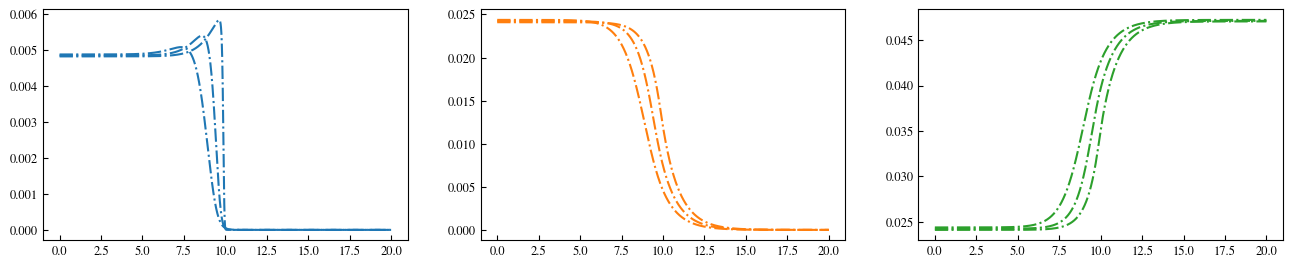

In [259]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

#ax[0].plot(X,rho_a_diff,color=ColorCycle[0])
#ax[1].plot(X,rho_b_diff,color=ColorCycle[1])
#ax[2].plot(X,rho_c_diff,color=ColorCycle[2])

ax[0].plot(X,rho_a_ooe1,color = ColorCycle[0],linestyle='-.',label='steep = 1')
ax[1].plot(X,rho_b_ooe1,color = ColorCycle[1],linestyle='-.',label='steep = 1')
ax[2].plot(X,rho_c_ooe1,color = ColorCycle[2],linestyle='-.',label='steep = 1')

ax[0].plot(X,rho_a_ooe5,color = ColorCycle[0],linestyle='-.',label='steep = 5')
ax[1].plot(X,rho_b_ooe5,color = ColorCycle[1],linestyle='-.',label='steep = 5')
ax[2].plot(X,rho_c_ooe5,color = ColorCycle[2],linestyle='-.',label='steep = 5')

ax[0].plot(X,rho_a_ooe10,color = ColorCycle[0],linestyle='-.',label='steep = 10')
ax[1].plot(X,rho_b_ooe10,color = ColorCycle[1],linestyle='-.',label='steep = 10')
ax[2].plot(X,rho_c_ooe10,color = ColorCycle[2],linestyle='-.',label='steep = 10')
#for i in range(3):
#    ax[i].legend()

## All the equilibrium solutions are consistent
#### Check that the fluxes are 0 for the eq solution, and look at the fluxes for the non-eq solution

In [254]:
A_ooe__diff_flux1 = diff_flux(rho_a_ooe1,VA1(X),dx)
B_ooe__diff_flux1 = diff_flux(rho_b_ooe1,VB1(X),dx)
C_ooe__diff_flux1 = diff_flux(rho_c_ooe1,VC1(X),dx)

A_ooe__diff_flux5 = diff_flux(rho_a_ooe5,VA5(X),dx)
B_ooe__diff_flux5 = diff_flux(rho_b_ooe5,VB5(X),dx)
C_ooe__diff_flux5 = diff_flux(rho_c_ooe5,VC5(X),dx)

A_ooe__diff_flux10 = diff_flux(rho_a_ooe10,VA10(X),dx)
B_ooe__diff_flux10 = diff_flux(rho_b_ooe10,VB10(X),dx)
C_ooe__diff_flux10 = diff_flux(rho_c_ooe10,VC10(X),dx)

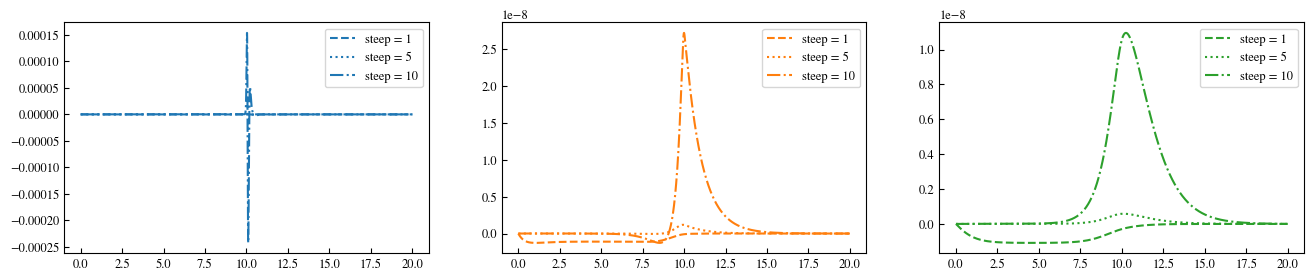

In [255]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)


ax[0].plot(X,A_ooe__diff_flux1,color = ColorCycle[0],linestyle='--',label='steep = 1')
ax[1].plot(X,B_ooe__diff_flux1,color = ColorCycle[1],linestyle='--',label='steep = 1')
ax[2].plot(X,C_ooe__diff_flux1,color = ColorCycle[2],linestyle='--',label='steep = 1')

ax[0].plot(X,A_ooe__diff_flux5,color = ColorCycle[0],linestyle=':',label='steep = 5')
ax[1].plot(X,B_ooe__diff_flux5,color = ColorCycle[1],linestyle=':',label='steep = 5')
ax[2].plot(X,C_ooe__diff_flux5,color = ColorCycle[2],linestyle=':',label='steep = 5')

ax[0].plot(X,A_ooe__diff_flux10,color = ColorCycle[0],linestyle='-.',label='steep = 10')
ax[1].plot(X,B_ooe__diff_flux10,color = ColorCycle[1],linestyle='-.',label='steep = 10')
ax[2].plot(X,C_ooe__diff_flux10,color = ColorCycle[2],linestyle='-.',label='steep = 10')

for i in range(3):
    ax[i].legend()

In [249]:
print("total diffusive flux A steepness 1 = "+str(np.sum(A_ooe__diff_flux1)*dx))
print("total diffusive flux A steepness 5 = "+str(np.sum(A_ooe__diff_flux5)*dx))
print("total diffusive flux A steepness 10= "+str(np.sum(A_ooe__diff_flux10)*dx))
print()
print("total diffusive flux B steepness 1 = "+str(np.sum(B_ooe__diff_flux1)*dx))
print("total diffusive flux B steepness 5 = "+str(np.sum(B_ooe__diff_flux5)*dx))
print("total diffusive flux B steepness 10= "+str(np.sum(B_ooe__diff_flux10)*dx))
print()
print("total diffusive flux C steepness 1 = "+str(np.sum(C_ooe__diff_flux1)*dx))
print("total diffusive flux C steepness 5 = "+str(np.sum(C_ooe__diff_flux5)*dx))
print("total diffusive flux C steepness 10= "+str(np.sum(C_ooe__diff_flux10)*dx))
print()
print("total diffusive flux total steepness 1 = "+str((np.sum(A_ooe__diff_flux1)+ np.sum(C_ooe__diff_flux1)+ np.sum(C_ooe__diff_flux1) )*dx))
print("total diffusive flux total steepness 5 = "+str((np.sum(A_ooe__diff_flux5)+ np.sum(C_ooe__diff_flux5)+ np.sum(C_ooe__diff_flux5) )*dx))
print("total diffusive flux total steepness 10= "+str((np.sum(A_ooe__diff_flux10)+np.sum(C_ooe__diff_flux10)+np.sum(C_ooe__diff_flux10))*dx))

total diffusive flux A steepness 1 = 0.0015100639099572
total diffusive flux A steepness 5 = 0.0013303442749029132
total diffusive flux A steepness 10= 0.0011368381793944997

total diffusive flux B steepness 1 = -0.024366964351971984
total diffusive flux B steepness 5 = -0.024222709037766615
total diffusive flux B steepness 10= -0.024096318935630412

total diffusive flux C steepness 1 = 0.022856900441435894
total diffusive flux C steepness 5 = 0.022892364730559334
total diffusive flux C steepness 10= 0.02295948070523761

total diffusive flux total steepness 1 = 0.047223864792828994
total diffusive flux total steepness 5 = 0.04711507373602158
total diffusive flux total steepness 10= 0.047055799589869725


In [52]:
print("total diffusive flux A steepness 1 = "+str(np.sum(A_ooe__diff_flux1)*dx))
print("total diffusive flux A steepness 5 = "+str(np.sum(A_ooe__diff_flux5)*dx))
print("total diffusive flux A steepness 10= "+str(np.sum(A_ooe__diff_flux10)*dx))
print()
print("total diffusive flux B steepness 1 = "+str(np.sum(B_ooe__diff_flux1)*dx))
print("total diffusive flux B steepness 5 = "+str(np.sum(B_ooe__diff_flux5)*dx))
print("total diffusive flux B steepness 10= "+str(np.sum(B_ooe__diff_flux10)*dx))
print()
print("total diffusive flux C steepness 1 = "+str(np.sum(C_ooe__diff_flux1)*dx))
print("total diffusive flux C steepness 5 = "+str(np.sum(C_ooe__diff_flux5)*dx))
print("total diffusive flux C steepness 10= "+str(np.sum(C_ooe__diff_flux10)*dx))
print()
print("total diffusive flux total steepness 1 = "+str((np.sum(A_ooe__diff_flux1)+ np.sum(C_ooe__diff_flux1)+ np.sum(C_ooe__diff_flux1) )*dx))
print("total diffusive flux total steepness 5 = "+str((np.sum(A_ooe__diff_flux5)+ np.sum(C_ooe__diff_flux5)+ np.sum(C_ooe__diff_flux5) )*dx))
print("total diffusive flux total steepness 10= "+str((np.sum(A_ooe__diff_flux10)+np.sum(C_ooe__diff_flux10)+np.sum(C_ooe__diff_flux10))*dx))

total diffusive flux A steepness 1 = -0.0017246234651993979
total diffusive flux A steepness 5 = -0.0013968920777106739
total diffusive flux A steepness 10= -0.0012722030126275626

total diffusive flux B steepness 1 = 0.001636336395228637
total diffusive flux B steepness 5 = 0.001315138916961915
total diffusive flux B steepness 10= 0.0011874481291372079

total diffusive flux C steepness 1 = 0.0001094111089410276
total diffusive flux C steepness 5 = 8.175314448216271e-05
total diffusive flux C steepness 10= 8.475487419728408e-05

total diffusive flux total steepness 1 = -0.0015058012473173426
total diffusive flux total steepness 5 = -0.0012333857887463487
total diffusive flux total steepness 10= -0.0011026932642329943
